In [1]:
#Data Wrangling
import pandas as pd
from scipy import stats
import numpy as np
import os
import nltk
from nltk import Text
from nltk.tokenize import word_tokenize, sent_tokenize, PunktSentenceTokenizer
from nltk.tokenize.punkt import PunktLanguageVars
from random import choices
import string
import matplotlib.pyplot as plt
from collections import Counter
import json
import re
import time
import gensim #library needed for word2vec
from gensim.models import Word2Vec


#Multiprocessing
from joblib import Parallel, delayed

#for visualization
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise
from sklearn.manifold import MDS, TSNE

In [2]:
def chrono_train_simple(current_corpus, previous_model, output_model):
    ''' Models the current corpus by initializing with the vectors of the previous model '''
    ''' and saves that new model for the next round of modeling '''
    total_sentences = len(current_corpus)
    model = Word2Vec.load(previous_model)
    model.train(current_corpus, total_examples = total_sentences, epochs = 200)
    model.save(output_model)


class callback(gensim.models.callbacks.CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        # record the start time of the training
    
    def on_epoch_begin(self, model):
        print(f'Epoch #{self.epoch} start ...', end=' ')
        self.ts = time.time()

    def on_epoch_end(self, model):
        # compute the time delta of the epoch relative to self.ts
        delta = time.time() - self.ts
        # print the delta time and loss after each epoch
        loss = model.get_latest_training_loss()
        print(f'Epoch #{self.epoch} took {int(delta // 60)}:{int(delta % 60)}m; loss = {loss}')
        self.epoch += 1

In [3]:
data = pd.read_json('../data/corpus_final.json')
sgg_df = pd.DataFrame(data)
len(sgg_df)

89

In [4]:
sgg_df['cleaned_sentences'][1:5]

1    [[Verhandlungen, der, schweizerisch, gemeinnüt...
2    [[Verhandlungen, Der, schweizerisch, gemeinnüß...
3    [[Verhandlungen, der, schweizerisch, gemeinnüt...
4    [[Verhandlungen, der, schweizerischgemeinnützi...
Name: cleaned_sentences, dtype: object

In [6]:
df_1830 = sgg_df[sgg_df['year'] < 1831]
df_1860 = sgg_df[(sgg_df['year'] >= 1831) & (sgg_df['year'] < 1861)]
df_1890 = sgg_df[(sgg_df['year'] >= 1861) & (sgg_df['year'] < 1891)]
df_1922 = sgg_df[(sgg_df['year'] >= 1891)]


epochs = [df_1830, df_1860, df_1890, df_1922]

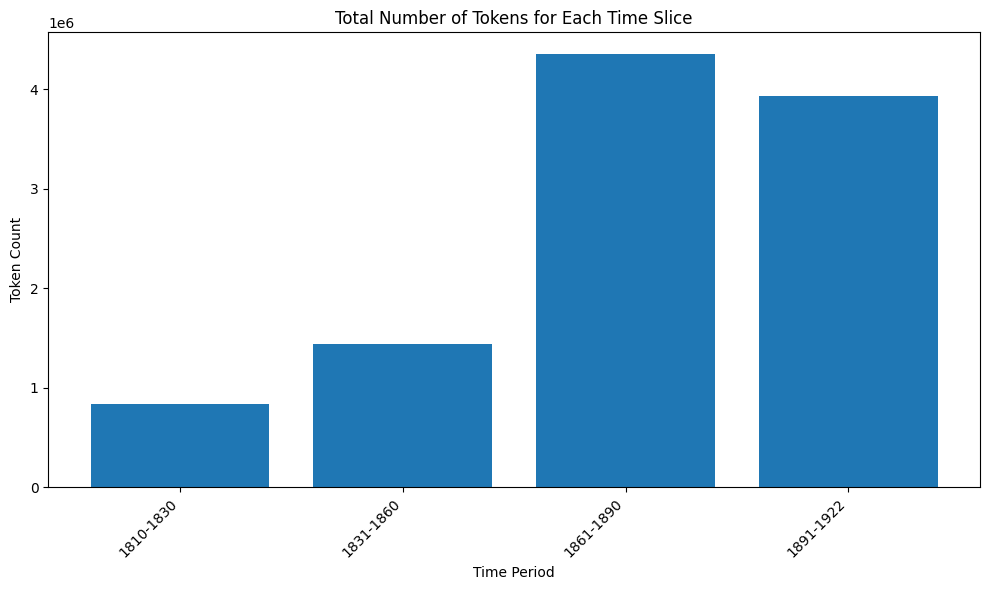

In [7]:

# Assuming you have the list of token counts already calculated
token_counts = [df['cleaned_sentences'].apply(lambda sentences: sum(len(sentence) for sentence in sentences)).sum() for df in epochs]

# Create a list of labels for the x-axis (DataFrame names)
df_names = ['1810-1830','1831-1860', '1861-1890', '1891-1922']  # Add your DataFrame names


# Plot the token counts
plt.figure(figsize=(10, 6))
plt.bar(df_names, token_counts)
plt.title('Total Number of Tokens for Each Time Slice')
plt.xlabel('Time Period')
plt.ylabel('Token Count')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Save the plot in the subfolder figures. 
plt.savefig('../figures/tokenumber_by_timeslice.png')

# Show the plot (optional)
plt.show()

In [8]:
epochs = {'df_1830': df_1830, 'df_1860': df_1860, 'df_1890': df_1890, 'df_1922': df_1922}

# Create variables for each epoch based on the DataFrame's key
for key, df in epochs.items():
    # Extract the year from the key (assuming the key is in the format 'df_YEAR')
    year = key.split('_')[1]
    
    # Create the variable dynamically with the year in the name
    globals()[f'sentences_{year}'] = [sentence for sublist in df['cleaned_sentences'].tolist() for sentence in sublist]

# Print the length of sentences for each epoch
for key, df in epochs.items():
    year = key.split('_')[1]
    print(f"Number of sentences in epoch {year}: {len(globals()[f'sentences_{year}'])}")

list_of_lists = [sentences_1830, sentences_1860, sentences_1890, sentences_1922]

Number of sentences in epoch 1830: 41286
Number of sentences in epoch 1860: 69988
Number of sentences in epoch 1890: 234170
Number of sentences in epoch 1922: 274519


In [9]:
total_tokens_count = sum(len(sentence) for sentence_list in sgg_df['cleaned_sentences'] for sentence in sentence_list)
print(total_tokens_count)

10562429


In [10]:
sentences = [sentence for sublist in sgg_df['cleaned_sentences'].tolist() for sentence in sublist]
len(sentences)

619963

In [14]:
modelW2 = gensim.models.Word2Vec(
    vector_size=300, # <= Setting Dimensionality
    window=2,
    min_count=10, # <= words should appear at least 10 times in the corpus
    sg=1,
    hs=0,
    negative=5,
    epochs=200, # <= Setting Number of Epochs 
    workers=4,
    sorted_vocab=1
)

In [15]:
modelW2.build_vocab(sentences) # <== takes long because corpus is large 

In [16]:
modelW2.train(
    sentences, 
    total_examples=modelW2.corpus_count, 
    epochs=modelW2.epochs,
    compute_loss=True, 
    callbacks=[callback()]
)

Epoch #0 start ... Epoch #0 took 0:7m; loss = 11406340.0
Epoch #1 start ... Epoch #1 took 0:7m; loss = 19903110.0
Epoch #2 start ... Epoch #2 took 0:7m; loss = 27452846.0
Epoch #3 start ... Epoch #3 took 0:7m; loss = 34338852.0
Epoch #4 start ... Epoch #4 took 0:6m; loss = 38968036.0
Epoch #5 start ... Epoch #5 took 0:7m; loss = 43525452.0
Epoch #6 start ... Epoch #6 took 0:6m; loss = 48042256.0
Epoch #7 start ... Epoch #7 took 0:7m; loss = 52438208.0
Epoch #8 start ... Epoch #8 took 0:7m; loss = 56823392.0
Epoch #9 start ... Epoch #9 took 0:7m; loss = 61169252.0
Epoch #10 start ... Epoch #10 took 0:6m; loss = 65475876.0
Epoch #11 start ... Epoch #11 took 0:6m; loss = 67403704.0
Epoch #12 start ... Epoch #12 took 0:7m; loss = 67889296.0
Epoch #13 start ... Epoch #13 took 0:7m; loss = 68374656.0
Epoch #14 start ... Epoch #14 took 0:6m; loss = 68874080.0
Epoch #15 start ... Epoch #15 took 0:6m; loss = 69373440.0
Epoch #16 start ... Epoch #16 took 0:6m; loss = 69884672.0
Epoch #17 start .

(1636470810, 2112485800)

In [18]:
modelW2.save('../models/W2_GENERALMODEL'+'.model')
modelW2.wv.save_word2vec_format('../models/W2_GENERALMODEL'+'.vectors')

In [19]:
modelW10 = gensim.models.Word2Vec(
    vector_size=300, # <= Setting Dimensionality
    window=10,
    min_count=10, # <= words should appear at least 10 times in the corpus
    sg=1,
    hs=0,
    negative=5,
    epochs=200, # <= Setting Number of Epochs 
    workers=4,
    sorted_vocab=1
)

In [20]:
modelW10.build_vocab(sentences) # <== takes long because corpus is large 

In [21]:
modelW10.train(
    sentences, 
    total_examples=modelW10.corpus_count, 
    epochs=modelW10.epochs,
    compute_loss=True, 
    callbacks=[callback()]
)

Epoch #0 start ... Epoch #0 took 0:20m; loss = 29255746.0
Epoch #1 start ... Epoch #1 took 0:20m; loss = 45648796.0
Epoch #2 start ... Epoch #2 took 0:20m; loss = 59928236.0
Epoch #3 start ... Epoch #3 took 0:19m; loss = 67547576.0
Epoch #4 start ... Epoch #4 took 0:19m; loss = 68492048.0
Epoch #5 start ... Epoch #5 took 0:19m; loss = 69467320.0
Epoch #6 start ... Epoch #6 took 0:19m; loss = 70486680.0
Epoch #7 start ... Epoch #7 took 0:19m; loss = 71535600.0
Epoch #8 start ... Epoch #8 took 0:19m; loss = 72612912.0
Epoch #9 start ... Epoch #9 took 0:19m; loss = 73678760.0
Epoch #10 start ... Epoch #10 took 0:19m; loss = 74784248.0
Epoch #11 start ... Epoch #11 took 0:19m; loss = 75889856.0
Epoch #12 start ... Epoch #12 took 0:19m; loss = 77021840.0
Epoch #13 start ... Epoch #13 took 0:19m; loss = 78147424.0
Epoch #14 start ... Epoch #14 took 0:19m; loss = 79287184.0
Epoch #15 start ... Epoch #15 took 0:21m; loss = 80439816.0
Epoch #16 start ... Epoch #16 took 0:20m; loss = 81589104.0


(1636452755, 2112485800)

In [22]:
modelW10.save('../models/W10_GENERALMODEL'+'.model')
modelW10.wv.save_word2vec_format('../models/W10_GENERALMODEL'+'.vectors')

In [23]:
modelW5 = gensim.models.Word2Vec(
    vector_size=300, # <= Setting Dimensionalityq
    window=5,
    min_count=10, # <= words should appear at least 10 times in the corpus
    sg=1,
    hs=0,
    negative=5,
    epochs=200, # <= Setting Number of Epochs 
    workers=4,
    sorted_vocab=1
)

In [24]:
modelW5.build_vocab(sentences) # <== takes long because corpus is large 

In [25]:
modelW5.train(
    sentences, 
    total_examples=modelW5.corpus_count, 
    epochs=modelW5.epochs,
    compute_loss=True, 
    callbacks=[callback()]
)

Epoch #0 start ... Epoch #0 took 0:12m; loss = 19410372.0
Epoch #1 start ... Epoch #1 took 0:13m; loss = 34113632.0
Epoch #2 start ... Epoch #2 took 0:12m; loss = 42986156.0
Epoch #3 start ... Epoch #3 took 0:12m; loss = 51742312.0
Epoch #4 start ... Epoch #4 took 0:12m; loss = 60433516.0
Epoch #5 start ... Epoch #5 took 0:12m; loss = 67247720.0
Epoch #6 start ... Epoch #6 took 0:13m; loss = 67895000.0
Epoch #7 start ... Epoch #7 took 0:12m; loss = 68562840.0
Epoch #8 start ... Epoch #8 took 0:12m; loss = 69250304.0
Epoch #9 start ... Epoch #9 took 0:12m; loss = 69963464.0
Epoch #10 start ... Epoch #10 took 0:12m; loss = 70682880.0
Epoch #11 start ... Epoch #11 took 0:12m; loss = 71406344.0
Epoch #12 start ... Epoch #12 took 0:12m; loss = 72153184.0
Epoch #13 start ... Epoch #13 took 0:12m; loss = 72894464.0
Epoch #14 start ... Epoch #14 took 0:12m; loss = 73651664.0
Epoch #15 start ... Epoch #15 took 0:13m; loss = 74416704.0
Epoch #16 start ... Epoch #16 took 0:13m; loss = 75185592.0


(1636467059, 2112485800)

In [26]:
modelW5.save('../models/W5_GENERALMODEL'+'.model')
modelW5.wv.save_word2vec_format('../models/W5_GENERALMODEL'+'.vectors')

In [27]:
chrono_train_simple(list_of_lists[0], "../models/W2_GENERALMODEL.model", "../models/W2_model01_1830.model")
chrono_train_simple(list_of_lists[1], "../models/W2_model01_1830.model", "../models/W2_model02_1860.model")
chrono_train_simple(list_of_lists[2], "../models/W2_model02_1860.model", "../models/W2_model03_1890.model")
chrono_train_simple(list_of_lists[3], "../models/W2_model03_1890.model", "../models/W2_model04_1922.model")

In [29]:
chrono_train_simple(list_of_lists[0], "../models/W10_GENERALMODEL.model", "../models/W10_model01_1830.model")
chrono_train_simple(list_of_lists[1], "../models/W10_model01_1830.model", "../models/W10_model02_1860.model")
chrono_train_simple(list_of_lists[2], "../models/W10_model02_1860.model", "../models/W10_model03_1890.model")
chrono_train_simple(list_of_lists[3], "../models/W10_model03_1890.model", "../models/W10_model04_1922.model")

In [28]:
chrono_train_simple(list_of_lists[0], "../models/W5_GENERALMODEL.model", "../models/W5_model01_1830.model")
chrono_train_simple(list_of_lists[1], "../models/W5_model01_1830.model", "../models/W5_model02_1860.model")
chrono_train_simple(list_of_lists[2], "../models/W5_model02_1860.model", "../models/W5_model03_1890.model")
chrono_train_simple(list_of_lists[3], "../models/W5_model03_1890.model", "../models/W5_model04_1922.model")